# Arrival Time Prediction - Pre Processing
This notebook is the first on the work on GP regression for arrival time prediction and deals with the pre processing before a model can be trained to make predictions.

First off lets get some libraries into scope and load the data.

In [8]:
import numpy as np
import pandas as pd
import time
import pickle
from datetime import datetime
from functools import reduce
import plot

data = pd.read_csv('../../bus203_all.csv')
data = data[data.journey_number < 10]
data.head()

,Unnamed: 0,timestamp,event,vehicle_id,line,longitude,latitude,direction,speed,station,journey_number,segment_number
0,0,2018-02-16T04:48:40.0000000+01:00,JourneyStartedEvent,5432,203,58.414238,15.571015,-1.000000,-1.0,NaN,1,1
1,1,2018-02-16T04:48:40.0000000+01:00,ObservedPositionEvent,5432,0,58.414238,15.571015,147.300003,0.0,NaN,1,1
2,2,2018-02-16T04:48:40.0000000+01:00,ArrivedEvent,5432,203,58.414238,15.571015,-1.000000,-1.0,Rydsv\xe4gens \xe4ndh\xe5llpl.,1,1
3,3,2018-02-16T04:48:41.0000000+01:00,ObservedPositionEvent,5432,0,58.414246,15.571012,147.300003,0.0,NaN,1,1
4,4,2018-02-16T04:48:42.0000000+01:00,ObservedPositionEvent,5432,0,58.414249,15.571008,147.300003,0.0,NaN,1,1


The names in the csv are very verbose, so we'll shorten them. This is of course a matter of preference but I prefer it this way.

In [2]:
data = data.rename(columns = {
                        'latitude': 'lat', 
                        'longitude': 'lon', 
                        'journey_number': 'traj', 
                        'segment_number': 'seg', 
                        'speed': 'speed',
                        'event': 'event',
                        'timestamp': 'timestamp'
                    })
data.head()

,Unnamed: 0,timestamp,event,vehicle_id,line,lon,lat,direction,speed,station,traj,seg
0,0,2018-02-16T04:48:40.0000000+01:00,JourneyStartedEvent,5432,203,58.414238,15.571015,-1.000000,-1.0,NaN,1,1
1,1,2018-02-16T04:48:40.0000000+01:00,ObservedPositionEvent,5432,0,58.414238,15.571015,147.300003,0.0,NaN,1,1
2,2,2018-02-16T04:48:40.0000000+01:00,ArrivedEvent,5432,203,58.414238,15.571015,-1.000000,-1.0,Rydsv\xe4gens \xe4ndh\xe5llpl.,1,1
3,3,2018-02-16T04:48:41.0000000+01:00,ObservedPositionEvent,5432,0,58.414246,15.571012,147.300003,0.0,NaN,1,1
4,4,2018-02-16T04:48:42.0000000+01:00,ObservedPositionEvent,5432,0,58.414249,15.571008,147.300003,0.0,NaN,1,1


## Stop Compression
There are many times where busses stop or drive very slowly. This causes a lot of data points to be clustered which will cause the GPs to prioritise getting the clustered areas right more than other areas, which we do not want. To prevent this we will filter out data points in every trajectory that are too close by some delta. However simply throwing the points aray will leave massive gaps in between them, which will not work at all for a GP with constant kernel lengthscale (which we will use). To combat this we will compress the data points during stops to a single data point which takes the mean value.

Worth noting is that coordinates are not in euclidian space but on a spherical surface so pythagoras theorem is no good here and we have to turn to haversine distance.

In [3]:
from math import radians, cos, sin, asin, sqrt, isnan

def parse_time(dt_str):
    dt, _, _ = dt_str.partition(".")
    return datetime.strptime(dt, "%Y-%m-%dT%H:%M:%S")

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers
    return c * r

def as_dict(d):
    return {
        'lat': d.lat,
        'lon': d.lon,
        'seg': d.seg,
        'speed': d.speed,
        'traj': d.traj,
        'timestamp': d.timestamp, 
        'event': d.event
    }


# I have no idea why, but this consistently returns one hour too much.
# Also, we actually call to_datetime twice (one more time outside of the function)
# which seems to be needed. No clue why this is the case.
def mean_timestamp(timestamps):
    dt = pd.to_datetime(timestamps.dropna().astype(np.int64).mean())
    dt = dt - pd.Timedelta(hours=1)
    return dt

def compress(data):
    df = pd.DataFrame(data)
    df.speed = np.max(df.speed, 0) # data contains -1 sentinel values for missing speed
    df2 = df.drop(['timestamp', 'event', 'seg'], axis=1).apply(np.mean, axis=0)
    df2['timestamp'] = mean_timestamp(df['timestamp'].apply(parse_time))
    df2['timestamp'] = pd.to_datetime(df2['timestamp'])
    
    contains_entered_event = lambda df : df.event.transform(lambda e : e == 'EnteredEvent').any()
    df2['event'] = 'EnteredEvent' if contains_entered_event(df) else 'ObservedPositionEvent'
    df2['seg'] = df.seg.min() # In the case of overlapping segments we let the data belong to the first
    tmp = as_dict(df2)
    return as_dict(df2)
    
t0 = time.time()

# Iterate through all data points, compare with latest 
# in compressed_data and append if it the distance is larger than 
# haversine delta. We also always append the final point, to make sure
# the trajectory is always complete.
delta = 4e-3 # approx. 4 metres
stop_list = []
rows = [as_dict(data.iloc[0])]
for i, d in data.iterrows():
    di = rows[len(rows)-1]
    if haversine(d.lat, d.lon, di.get('lat'), di.get('lon')) < delta:
        stop_list.append(as_dict(d))
    else:
        if stop_list:
            rows.append(compress(stop_list))
        stop_list = []
        rows.append(as_dict(d))
        
    #if haversine(d.lat, d.lon, di.get('lat'), di.get('lon')) > delta or d.progress == 1:
    #    rows.append(as_dict(d))

compressed_data = pd.DataFrame(rows)

elapsed = time.time() - t0
print("Data processed in", elapsed, " seconds")
compressed_data

Data processed in 3.342054605484009  seconds


,event,lat,lon,seg,speed,timestamp,traj
0,JourneyStartedEvent,15.571015,58.414238,1,-1.00,2018-02-16 03:48:40.000000000,1.0
1,ObservedPositionEvent,15.571012,58.414258,1,0.00,2018-02-16 03:48:46.176470528,1.0
2,DepartedEvent,15.571187,58.414196,1,-1.00,2018-02-16 03:48:54.000000000,1.0
3,ObservedPositionEvent,15.571016,58.414265,1,0.41,2018-02-16 03:48:55.000000000,1.0
4,ObservedPositionEvent,15.571037,58.414248,1,1.18,2018-02-16 03:48:57.000000000,1.0
5,ObservedPositionEvent,15.571072,58.414230,1,1.49,2018-02-16 03:48:59.000000000,1.0
6,ObservedPositionEvent,15.571098,58.414215,1,1.69,2018-02-16 03:49:00.000000000,1.0
7,ObservedPositionEvent,15.571137,58.414204,1,2.31,2018-02-16 03:49:01.000000000,1.0
8,ObservedPositionEvent,15.571187,58.414196,1,2.57,2018-02-16 03:49:01.500000000,1.0
9,ObservedPositionEvent,15.571241,58.414196,1,2.72,2018-02-16 03:49:03.000000000,1.0


## Computing arrival times
The goal is to estimate arrival time given a trajectory, but to do that we first need to annotate the trajectories in the data with the actual arrival times. We do this by first creating a dictionary which maps trajectories to arrival times and save it for later. This will be used to annotate each data point.

In [4]:
def parse_time(dt_str):
    dt, _, _ = dt_str.partition(".")
    return datetime.strptime(dt, "%Y-%m-%dT%H:%M:%S")

def traj_travel_time(data, traj):
    traj_data = data[data.traj == traj]
    segs = traj_data.seg.unique()
    return {seg : seg_travel_time(traj_data, seg) for seg in segs}

def seg_travel_time(traj_data, seg):
    seg_data = traj_data[traj_data.seg == seg].sort_values('timestamp')
    start_time = seg_data.iloc[0].timestamp # parse_time(seg_data.iloc[0].timestamp)
    arrival_time = seg_data.iloc[-1].timestamp #parse_time(seg_data.iloc[-1].timestamp)
    return arrival_time - start_time

t0 = time.time()
trajs = compressed_data.traj.unique()
travel_times = {traj : traj_travel_time(compressed_data, traj) for traj in trajs}
elapsed = time.time() - t0
print("Data processed in", elapsed, " seconds")
travel_times
#with open('travel_times.pkl', 'wb') as handle:
#    pickle.dump(travel_times, handle, protocol=pickle.HIGHEST_PROTOCOL)


Data processed in 0.1136925220489502  seconds


{1.0: {1: Timedelta('0 days 00:01:12'),
  2: Timedelta('0 days 00:00:52'),
  3: Timedelta('0 days 00:00:41'),
  4: Timedelta('0 days 00:00:50'),
  5: Timedelta('0 days 00:00:51'),
  6: Timedelta('0 days 00:01:06'),
  7: Timedelta('0 days 00:01:21.500000'),
  8: Timedelta('0 days 00:00:25'),
  9: Timedelta('0 days 00:02:02'),
  10: Timedelta('0 days 00:00:39'),
  11: Timedelta('0 days 00:00:37')},
 2.0: {1: Timedelta('0 days 00:03:12'),
  2: Timedelta('0 days 00:01:11'),
  3: Timedelta('0 days 00:01:03'),
  4: Timedelta('0 days 00:00:54'),
  5: Timedelta('0 days 00:00:57'),
  6: Timedelta('0 days 00:01:28'),
  7: Timedelta('0 days 00:01:33'),
  8: Timedelta('0 days 00:00:47'),
  9: Timedelta('0 days 00:02:26'),
  10: Timedelta('0 days 00:01:05'),
  11: Timedelta('0 days 00:01:00.500000')},
 3.0: {1: Timedelta('0 days 00:02:59.500000'),
  2: Timedelta('0 days 00:00:54'),
  3: Timedelta('0 days 00:01:49'),
  4: Timedelta('0 days 00:00:44'),
  5: Timedelta('0 days 00:00:49'),
  6: Timedelt

Now let's annotate the data. In this case we are going to add a field for "time remaining". In addition we are going to need to know the _progression_ of each trajectory, which is computed by normalising the temporal progression. This is needed to train a synchronisation GP before making the predictions. Observe that this is done after stop compression, which means that we assume that the information lost on how long a trajectory is spatially stationary is irrelevant for our predictions. The following chunk annotates the data with time remaining and normalised temporal progression. Beware that this takes a while!

In [11]:
t0 = time.time()
time_left = pd.DataFrame({'time_left': np.zeros(compressed_data.shape[0])})
progress = pd.DataFrame({'progress': np.zeros(compressed_data.shape[0])})
print(time_left.shape)
print(compressed_data.shape)
reverse_rows = compressed_data.iloc[::-1]
last_stop_timestamp = reverse_rows.iloc[0].timestamp
print(reverse_rows.head())
for i, d in reverse_rows.iterrows():
    t = d.timestamp
    if d.event == 'EnteredEvent':
        last_stop_timestamp = t
    d_time = (last_stop_timestamp - t).seconds
    time_left.iloc[i] = d_time
    progress.iloc[i] = 1 - (d_time / travel_times[d.traj][d.seg].seconds)
    
progress_data = pd.concat([
            compressed_data[['lat', 'lon', 'traj', 'seg', 'speed']],
            time_left,
            progress],
            axis = 1)

print("Data processed in", elapsed, " seconds")
elapsed = time.time() - t0
print(progress_data[progress_data.traj == 1].head())
#progress_data['progress'] = np.zeros(progress_data.shape[0])
#for i, d in progress_data.iterrows():
#    progress_data.iloc[i]['progress'] = 1 - (d.time_left - travel_times[d.traj][d.seg].seconds)
#progress_data

(5800, 1)
(5800, 7)
                      event        lat        lon  seg  speed  \
5799  ObservedPositionEvent  15.602742  58.407948   11   9.10   
5798  ObservedPositionEvent  15.602587  58.407928   11   8.64   
5797  ObservedPositionEvent  15.602435  58.407913   11   8.12   
5796  ObservedPositionEvent  15.602301  58.407898   11   7.66   
5795  ObservedPositionEvent  15.602165  58.407887   11   6.94   

               timestamp  traj  
5799 2018-02-16 06:05:39   9.0  
5798 2018-02-16 06:05:38   9.0  
5797 2018-02-16 06:05:37   9.0  
5796 2018-02-16 06:05:36   9.0  
5795 2018-02-16 06:05:35   9.0  
Data processed in 1.8869554996490479  seconds
         lat        lon  traj  seg  speed  time_left  progress
0  15.571015  58.414238   1.0    1  -1.00       72.0  0.000000
1  15.571012  58.414258   1.0    1   0.00       65.0  0.097222
2  15.571187  58.414196   1.0    1  -1.00       58.0  0.194444
3  15.571016  58.414265   1.0    1   0.41       57.0  0.208333
4  15.571037  58.414248   1.0 

We can see that the majority of the points that are removed are taken from the start of trajectories, which makes sense since the bus has a lot of dwell time and slow speed in the beginning. We also see a huge problem with the first route. The buss has a _massive_ dwell time on this point, more than half the time spent on the segment. This makes predictions very hard.

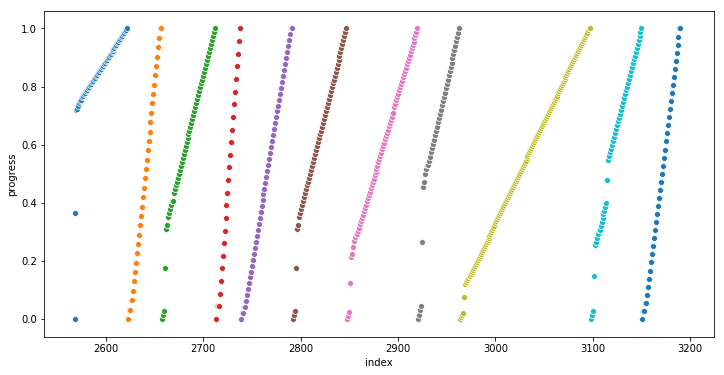

In [13]:
traj_to_plot = progress_data[progress_data.traj == 5]
plot.traj_progress(traj_to_plot)

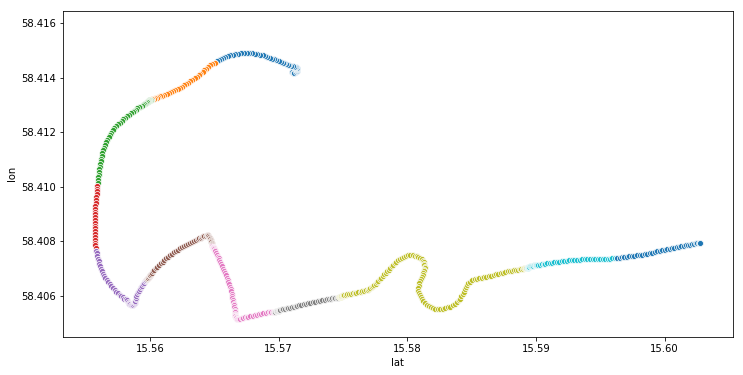

In [14]:
plot.traj_segments(traj_to_plot)

## Filter outlier
Plotting the data show one outlier, how it got there is beyond me, but we filter it out.

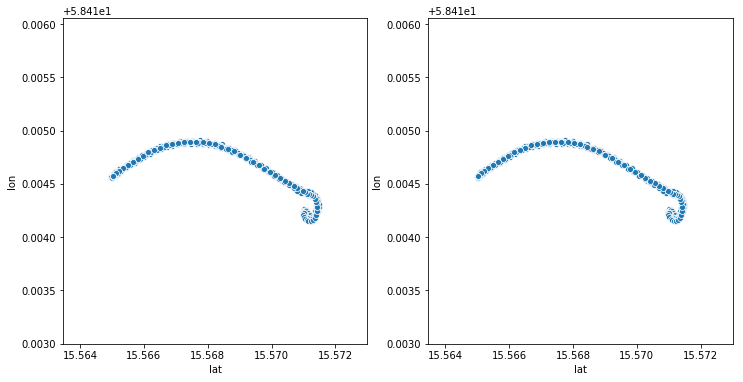

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
from math import ceil

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
seg = progress_data[progress_data.seg == 1]
sns.scatterplot(x="lat", y="lon", data=seg, ax=ax[0])

d = progress_data # just a shorted name for the query
filtered_data = d[((d.lat > 15.562) & (d.seg == 1)) | (d.seg != 1)]       
seg = filtered_data[filtered_data.seg == 1]
sns.scatterplot(x="lat", y="lon", data=seg, ax=ax[1])

## Enforce smoothness
A property that we want from the synchroinisation GP that we will train is for it to be a smooth mapping with respect to spatial progress, that is, we want regions that are close progressionwise in the functions domain to be close in its codomain. This is not something a GP guarantees at all, so to force it to learn something closer to what we want the data is duplicated with a small offset orthogonal to progression. We call these data points support data points, and they are saved in their own data set.

This is meaningful only for training data, so at this point we split the data into train and test sets.

In [17]:
n_trajs = len(filtered_data.traj.unique())
n_train = round(n_trajs*0.8)
train_ixs = frozenset(np.random.randint(0, n_trajs-1, n_train))

train_data = filtered_data[filtered_data.traj.transform(lambda x: x in train_ixs)]
test_data = filtered_data[filtered_data.traj.transform(lambda x: x not in train_ixs)]
train_data.to_pickle('train.pkl')
test_data.to_pickle('test.pkl')

In [18]:
from numpy.linalg import norm
tmp_data = []
N = train_data.shape[0]
t0 = time.time()
d = 5 # amount of random draws

def move_to(data, lat, lon):
    data.lat = lat
    data.lon = lon
    return data

for n in range(N-1):
    cur = train_data.iloc[n]
    nxt = train_data.iloc[n+1]
    d_lat = nxt.lat - cur.lat
    d_lon = nxt.lon - cur.lon
    u = np.array([-d_lon, d_lat]) # orthogonal to progression 
    u = u/norm(u)
    
    v = np.array([cur.lat, cur.lon]) # current data point position
    sigma = 5e-5 # taken by simply looking at the results for something that looks decent
    draws = np.random.normal(0, sigma, d)
    support_latlon = [v + u*draw for draw in draws]
    
    support_data = [move_to(cur.copy(), lat, lon) for lat, lon in support_latlon]
    if [x for x in support_latlon if isnan(x[0])]:
        print(cur)
        print(nxt)
        
    tmp_data = tmp_data + support_data
    
support_data = pd.DataFrame(tmp_data)
support_data.to_pickle('support.pkl')

from math import isnan
print(support_data[support_data.lat.transform(lambda x: isnan(x))])

elapsed = time.time() - t0
print("Data processed in", elapsed, " seconds")

#plot.traj_segment_grid(support_data, 'lat', 'lon')

C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


lat          15.565062
lon          58.414597
traj          1.000000
seg           1.000000
speed        -1.000000
time_left     0.000000
progress      1.000000
Name: 58, dtype: float64
lat          15.565062
lon          58.414597
traj          1.000000
seg           2.000000
speed         4.620000
time_left    52.000000
progress      0.000000
Name: 59, dtype: float64
lat          15.564622
lon          58.414425
traj          1.000000
seg           2.000000
speed        -1.000000
time_left    31.000000
progress      0.403846
Name: 70, dtype: float64
lat          15.564622
lon          58.414425
traj          1.000000
seg           2.000000
speed         5.600000
time_left    30.000000
progress      0.423077
Name: 71, dtype: float64
lat          15.560082
lon          58.413158
traj          1.000000
seg           2.000000
speed        -1.000000
time_left     0.000000
progress      1.000000
Name: 101, dtype: float64
lat          15.560082
lon          58.413158
traj          1.000000


Name: 1351, dtype: float64
lat          15.564623
lon          58.414406
traj          3.000000
seg           2.000000
speed         4.370000
time_left    32.000000
progress      0.407407
Name: 1352, dtype: float64
lat          15.560186
lon          58.413216
traj          3.000000
seg           2.000000
speed        -1.000000
time_left     0.000000
progress      1.000000
Name: 1384, dtype: float64
lat           15.560186
lon           58.413216
traj           3.000000
seg            3.000000
speed          5.140000
time_left    109.000000
progress       0.000000
Name: 1385, dtype: float64
lat          15.555882
lon          58.410084
traj          3.000000
seg           3.000000
speed        -1.000000
time_left     0.000000
progress      1.000000
Name: 1440, dtype: float64
lat          15.555882
lon          58.410084
traj          3.000000
seg           4.000000
speed         5.650000
time_left    44.000000
progress      0.000000
Name: 1441, dtype: float64
lat          15.555889
lon

Name: 2331, dtype: float64
lat           15.575042
lon           58.406002
traj           4.000000
seg            9.000000
speed          3.900000
time_left    128.000000
progress       0.163399
Name: 2332, dtype: float64
lat          15.589684
lon          58.407085
traj          4.000000
seg          10.000000
speed        -1.000000
time_left    45.000000
progress      0.347826
Name: 2469, dtype: float64
lat          15.589684
lon          58.407085
traj          4.000000
seg          10.000000
speed         6.370000
time_left    44.000000
progress      0.362319
Name: 2470, dtype: float64
lat          15.602694
lon          58.407932
traj          4.000000
seg          11.000000
speed         4.470000
time_left     0.000000
progress      1.000000
Name: 2566, dtype: float64
lat          15.602694
lon          58.407932
traj          4.000000
seg          11.000000
speed        -1.000000
time_left     0.000000
progress      1.000000
Name: 2567, dtype: float64
lat          15.564575
lon

      lat  lon  traj   seg  speed  time_left  progress
58    NaN  NaN   1.0   1.0  -1.00        0.0  1.000000
58    NaN  NaN   1.0   1.0  -1.00        0.0  1.000000
58    NaN  NaN   1.0   1.0  -1.00        0.0  1.000000
58    NaN  NaN   1.0   1.0  -1.00        0.0  1.000000
58    NaN  NaN   1.0   1.0  -1.00        0.0  1.000000
70    NaN  NaN   1.0   2.0  -1.00       31.0  0.403846
70    NaN  NaN   1.0   2.0  -1.00       31.0  0.403846
70    NaN  NaN   1.0   2.0  -1.00       31.0  0.403846
70    NaN  NaN   1.0   2.0  -1.00       31.0  0.403846
70    NaN  NaN   1.0   2.0  -1.00       31.0  0.403846
101   NaN  NaN   1.0   2.0  -1.00        0.0  1.000000
101   NaN  NaN   1.0   2.0  -1.00        0.0  1.000000
101   NaN  NaN   1.0   2.0  -1.00        0.0  1.000000
101   NaN  NaN   1.0   2.0  -1.00        0.0  1.000000
101   NaN  NaN   1.0   2.0  -1.00        0.0  1.000000
104   NaN  NaN   1.0   3.0  -1.00       40.0  0.024390
104   NaN  NaN   1.0   3.0  -1.00       40.0  0.024390
104   NaN 